## Tinder 4 Movies

In [2]:
# import functions
from shits import stemming_tokenizer, create_cosine, recommend_movies, create_combination

# import libraries
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

## Daten einlesen & bereinigen
Wir lesen hier die Dateien ein und führen sie zusammen anhand der tmdbId --> So bekommen wir die entsprechende movieIds

In [3]:
df_links = pd.read_csv("ml-25m/links.csv")
df_tmdb_movies = pd.read_csv("tmdb_movies.csv", sep="\t")

# rename id column so that we can merge later
df_tmdb_movies.rename(columns={'id':'tmdbId'}, inplace=True)

# merge movielens movies with tmdb movies
df_movies = pd.merge(df_links, df_tmdb_movies, on='tmdbId')
df_movies.head()

,movieId,imdbId,tmdbId,Unnamed: 0,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,895,105729,79782.0,0,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
1,895,105729,79782.0,13349,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
2,181393,1684935,79782.0,0,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
3,181393,1684935,79782.0,13349,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
4,1115,114472,141210.0,1,False,NaN,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",NaN,...,2012-10-12,0,6,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Sleepover,False,6.6,8


Hier extrahieren wir die relevanten Daten aus den angegebenen Spalten, weil sie dort verschachtelt sind.

In [4]:
# extract data from dictionaries and list, separate key values by '|'

def extract_values(data):
    return data.apply(lambda x: '|'.join([i['name'] for i in eval(x)]))

df_movies['genres'] = extract_values(df_movies["genres"])
df_movies['spoken_languages'] = extract_values(df_movies["spoken_languages"])
df_movies['production_companies'] = extract_values(df_movies['production_companies'])
df_movies['production_countries'] = extract_values(df_movies['production_countries'])

Hier haben wir die Spalten definiert und geordnet, die wir benötigen (alle anderen wurden automatisch entfernt)

In [5]:
col_order = [
    "movieId", 
    "title", 
    "genres", 
    "overview", 
    "release_date", 
    "runtime", 
    "original_language",
    "spoken_languages", 
    "production_companies",
    "production_countries",
]

df_movies = df_movies[col_order]

Hier wurden die Daten weiter bereinigt

In [6]:
# remove duplicate rows (there are some duplicate movies with different movieId's, thats why we use difference)
df_movies = df_movies.drop_duplicates(subset = df_movies.columns.difference(["movieId"]))

# drop rows with runtime 30 --> remove short films because they are not relevant in our opinion
df_movies = df_movies.drop(df_movies[df_movies["runtime"] < 30].index)

# remove all overviews that are nan
df_movies = df_movies.dropna(subset=["overview"])

In [7]:
df_movies

,movieId,title,genres,overview,release_date,runtime,original_language,spoken_languages,production_companies,production_countries
0,895,Venice,Drama|Romance,An atmospheric coming-of-age story featuring a...,2010-06-11,110,pl,Český|Deutsch|Polski|Pусский,Akson Studio|ITI Cinema,Poland
6,2679,A Place at the Table,Documentary,"Using personal stories, this powerful document...",2012-03-22,84,en,English,,United States of America
11,4249,Kingdom Come,Comedy|Documentary,"The documentary, Kingdom Come follows a first-...",2011-01-01,88,en,,,
12,4484,"Camille Claudel, 1915",Drama,"Winter, 1915. Confined by her family to an asy...",2013-03-13,95,fr,Français,ARTE France Cinéma|Canal+|3B Productions|Picta...,France
16,5904,My Kingdom,Drama|Action|Romance,"In the 19th century, the Prince Regent of the ...",2011-09-08,95,zh,广州话 / 廣州話|普通话,,China
...,...,...,...,...,...,...,...,...,...,...
19973,209133,The Riot and the Dance: Earth,Documentary,"This nature/science documentary, showcases the...",2018-03-19,110,en,,,
19974,209143,The Painting,Documentary|History|Animation,"For three and a half centuries, from the same ...",2019-11-08,107,es,English|Français|Italiano|Español,TVE|TeleMadrid|Mare Films,Spain
19975,209145,Liberte,Drama|History,"1774, shortly before the French Revolution, so...",2019-09-04,132,fr,Français|Italiano|Deutsch,CNC|Medienboard Berlin-Brandenburg|Idéale Audi...,Germany|Spain|France|Portugal
19977,209157,We,Drama,During a scorching summer in a Belgian-Dutch b...,2018-07-12,100,nl,Nederlands,New AMS Film Company,Belgium|Netherlands


#### Movie Ratings
Hier lesen wir die Filmbewertungen ein. Wir haben Filme von der TMDB API abgefragt und gespeichert und wir wollen jetzt nur die bewerteten Filme behalten. Darum schauen wir, ob die movieIds übereinstimmen, falls ja dann werden diese Bewertungen beibehalten. Alle andere Bewertungen werden automatisch gelöscht, da sie irrelevant sind.

Danach werden weitere Bereinigungsmethoden angewendet, wie den Timestamp zu konvertieren und die beiden Dataframes zusammenzufügen.

So können wir dann Bewertungen plausibilisieren --> falls diese Daten unmöglich sind (zb eine Bewertung wurde vor der Veröffentlichung vom Film erstellt), werden sie gelöscht.

In [8]:
df_ratings = pd.read_csv("ml-25m/ratings.csv")

In [9]:
# only keep movie ratings where the movieId is in df_movies
df_ratings = df_ratings[df_ratings["movieId"].isin(list(df_movies["movieId"]))]

# convert timestamp to datetime
df_ratings["date"] = [datetime.fromtimestamp(x) for x in df_ratings["timestamp"]]

# drop timestamp column
df_ratings.drop("timestamp", axis = 1, inplace = True)

# merge movies and ratings on movieId
df_movies_ratings = pd.merge(df_ratings, df_movies, on = "movieId")

# drop rows where the ratings were submitted before the movie released
df_movies_ratings = df_movies_ratings[df_movies_ratings["date"] > df_movies_ratings["release_date"]]

# drop columns because they are useless now
df_movies_ratings.drop(["date", "release_date"], axis = 1, inplace = True)

Hier ist ein weiteres Beispiel von Daten zu plausibilisieren.

In [10]:
# No user has rated the same movie twice
df_movies_ratings[df_movies_ratings.duplicated(subset = ["userId", "movieId"])]

,userId,movieId,rating,title,genres,overview,runtime,original_language,spoken_languages,production_companies,production_countries


Hier wollen wir die meistbewertesten Filme anschauen und dazu auch noch nur Filme betrachten, die mehr als 10 Bewertungen aufweisen.

In [11]:
# group by title and count ratings
df_movies_sum_ratings = df_movies_ratings.groupby("title")["rating"].count().sort_values(ascending = False).reset_index()

# show movies with more than 10 ratings (only 6.6k movies)
df_movies_10_ratings = df_movies_sum_ratings[df_movies_sum_ratings["rating"] > 10]
df_movies_10_ratings

,title,rating
0,Inception,38895
1,Interstellar,22634
2,Django Unchained,20686
3,The Dark Knight Rises,19911
4,Shutter Island,18886
...,...,...
6473,Radiostars,11
6474,Platinum Data,11
6475,Swallows and Amazons,11
6476,Barbie: Dolphin Magic,11


Nach diesem Schritt blieben leider nur noch 6.6k Filme übrig. Deshalb haben wir unsere Modelle bisher ohne diesen Schritt weiter bearbeitet. 

## Explorative Datenanalyse
Um unsere Daten besser zu verstehen, führen wir eine Explorative Datenanalyse durch.

#### 1. Welches sind die am häufigsten geschauten Genres/Filme?


In [12]:
# separate genres and add them as columns, 0 = not in genre, 1 = in genre
dum = df_movies_ratings['genres'].str.get_dummies(sep = '|')
df_genres = pd.concat([df_movies_ratings, dum], axis=1)
df_genres.head()

,userId,movieId,rating,title,genres,overview,runtime,original_language,spoken_languages,production_companies,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,3,73321,4.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",118,en,English,Alcon Entertainment|Silver Pictures,...,0,0,0,0,0,1,0,1,0,0
1,13,73321,3.5,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",118,en,English,Alcon Entertainment|Silver Pictures,...,0,0,0,0,0,1,0,1,0,0
2,38,73321,3.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",118,en,English,Alcon Entertainment|Silver Pictures,...,0,0,0,0,0,1,0,1,0,0
3,44,73321,5.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",118,en,English,Alcon Entertainment|Silver Pictures,...,0,0,0,0,0,1,0,1,0,0
4,65,73321,5.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",118,en,English,Alcon Entertainment|Silver Pictures,...,0,0,0,0,0,1,0,1,0,0


Es gibt Filme, die mehrere Genres haben (z.B. wie oben zu sehen, "The Book of Eli") --> Diese 4 Genres werden alle zu dem jeweiligen Genre dazugezählt. 

C:\Users\Alex\AppData\Local\Temp/ipykernel_18688/2277631516.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([float(x/1000000) for x in ax.get_yticks()])


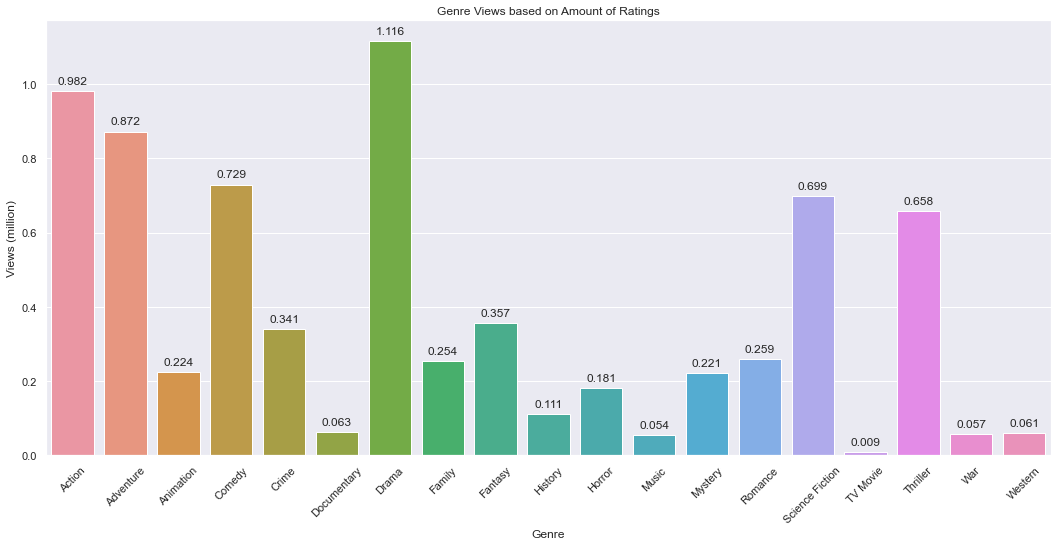

In [13]:
sns.set(rc={'figure.figsize':(18,8)})

# create barplot with the amount of genre occurences
ax = sns.barplot(data = df_genres.iloc[:,-19:].sum().reset_index(), x = "index", y = 0)

# remove "1e6" from plot
ax.ticklabel_format(style='plain', axis='y')

# devide y axis by 1 million (easier to read on the graph)
ax.set_yticklabels([float(x/1000000) for x in ax.get_yticks()])

# add text in millions, rounded by 3 decimals to bars
for p in ax.patches:
    ax.annotate(format(p.get_height()/1000000, '.3f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax.set(xlabel='Genre', ylabel='Views (million)', title="Genre Views based on Amount of Ratings")
plt.xticks(rotation = 45)
plt.show()

Häufigsten Filme

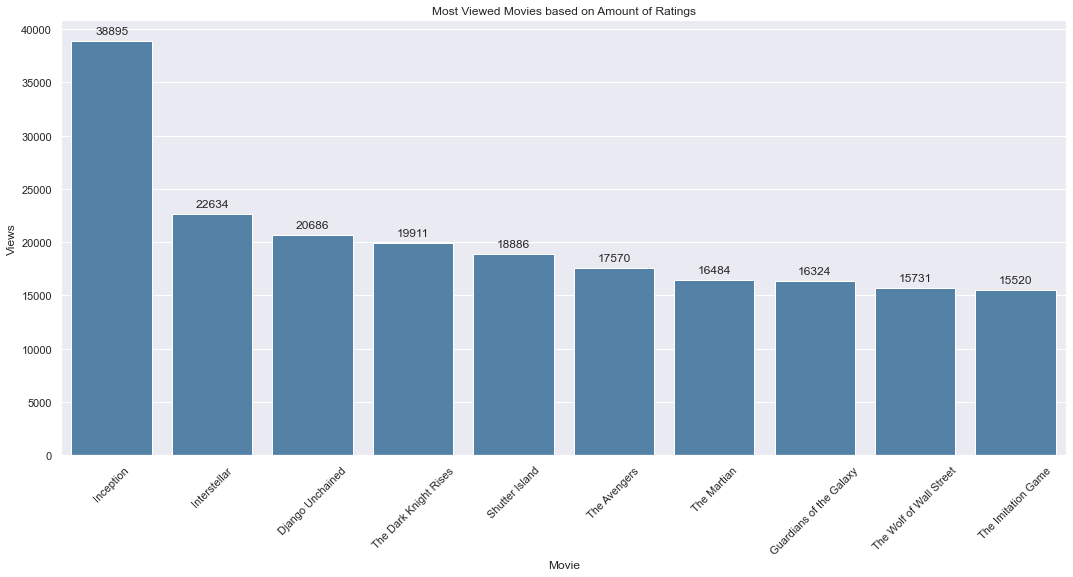

In [14]:
# create barplot with the most viewed movies and add text to bars
ax = sns.barplot(data = df_movies_sum_ratings.iloc[:10,:], x = "title", y = "rating", color = "steelblue")

# add text to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax.set(xlabel = 'Movie', ylabel = 'Views', title = "Most Viewed Movies based on Amount of Ratings")
plt.xticks(rotation = 45)
plt.show()

#### 2. Wie verteilen sich die Kundenratings gesamthaft und nach Genres?
Hier erstellen wir ein Dataframe mit den Ratings und Genre pro Film, um diese nacher einfacher zu plotten

In [15]:
lst2 = []

# loop through all genres (last 19 columns)
for i in df_genres.iloc[:,-19:].columns:
    # if rating is 1, add genre to list
    lst2.append([i, df_genres[df_genres[i] == 1]["rating"].tolist()])

# create dataframe from lst2 and unpack the list of ratings
df_genres_ratings = pd.DataFrame(lst2, columns = ["Genre", "Rating"])

# explode the list of ratings --> each rating will turn into a row with its corresponding genre
df_genres_ratings = df_genres_ratings.explode("Rating")
df_genres_ratings

,Genre,Rating
0,Action,4.0
0,Action,3.5
0,Action,3.0
0,Action,5.0
0,Action,5.0
...,...,...
18,Western,2.5
18,Western,0.5
18,Western,0.5
18,Western,1.0


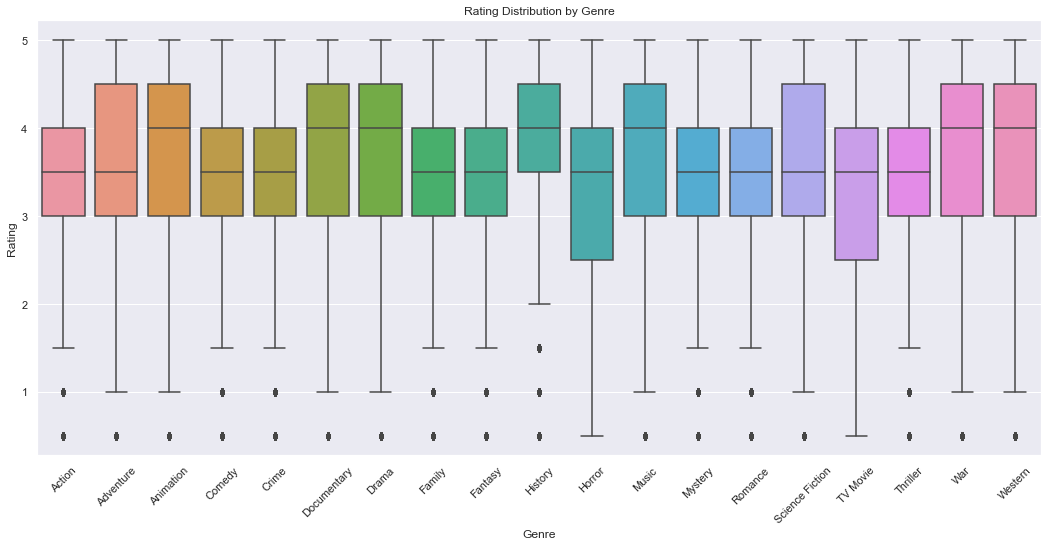

In [16]:
# plot rating by genre

ax = sns.boxplot(data = df_genres_ratings, x = "Genre", y = "Rating")
ax.set(xlabel = "Genre", ylabel = "Rating", title = "Rating Distribution by Genre")
plt.xticks(rotation = 45)
plt.show()

die Bewertungen von Horror und TV Movie Genres sind am meisten verstreut. Die Bewertungen von History fielen am höchsten aus.

#### 3. Wie verteilen sich die mittleren Kundenratings pro Film?
Alle Filme gruppieren und die Durchschnittsbewertung pro Film plotten

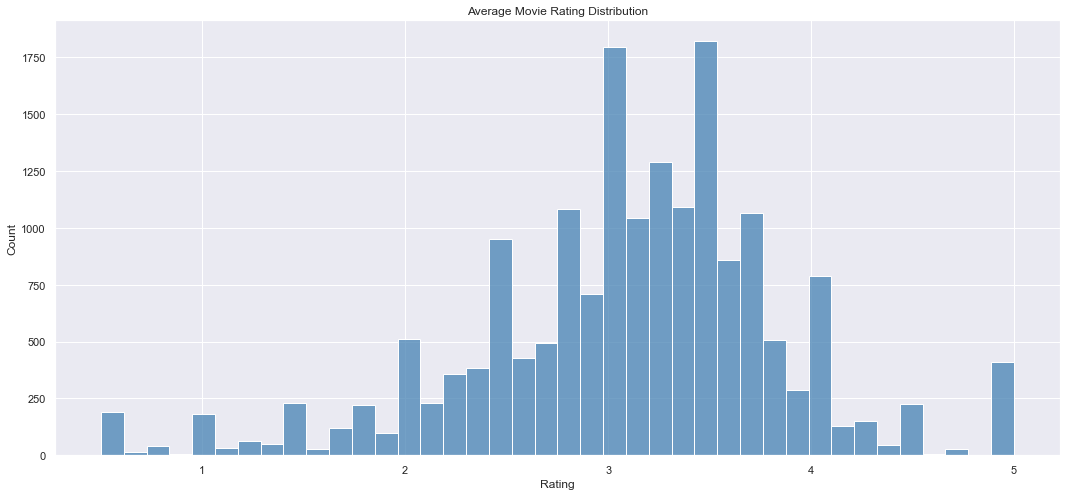

In [17]:
# group title and calculate average rating
df_movies_avg_ratings = df_movies_ratings.groupby("title")["rating"].mean().reset_index()

# create histogram with average ratings
ax = sns.histplot(data = df_movies_avg_ratings, x = "rating", bins = 40, color="steelblue")

# set labels
ax.set(xlabel = "Rating", ylabel = "Count", title = "Average Movie Rating Distribution")

plt.show()

Hier sehen wir, dass die meisten Filme durchschnittlich zwischen 3 & 3.5 bewertet wurden und dass die Verteilung aller Bewertungen ungefähr normalverteilt ist.

#### 4. Wie stark streuen die Ratings von individuellen Kunden?

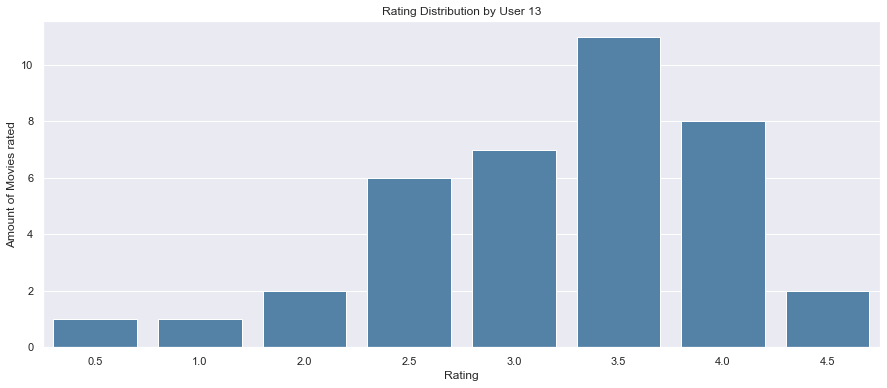

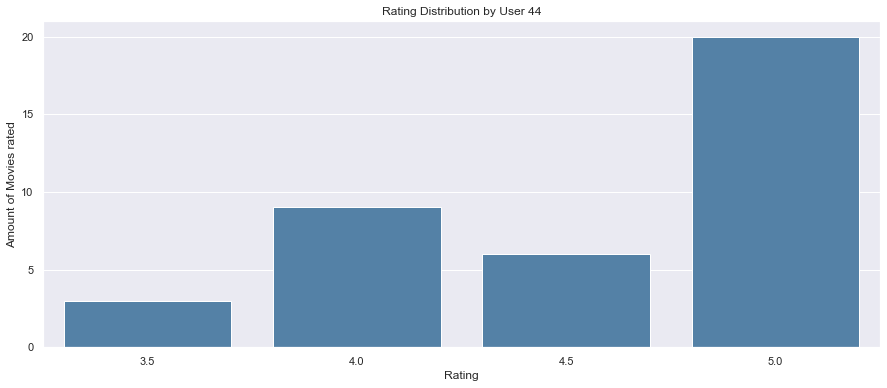

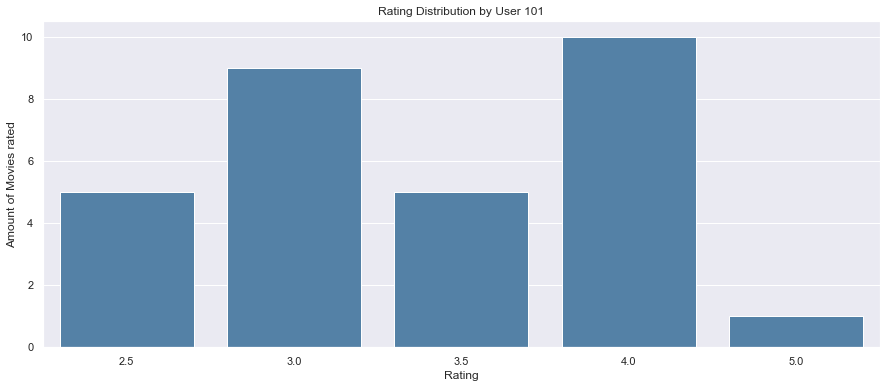

In [18]:
def user_rating(id):
    sns.set(rc={'figure.figsize':(15,6)})

    # create barplot with ratings from user
    ax = sns.barplot(data = df_genres[df_genres["userId"] == id].groupby("rating")["title"].count().reset_index(), x = "rating", y = "title", color = "steelblue")

    # change y axis to integer (example: because its not possible to rate 12.5 movies)
    plt.locator_params(axis='y', integer = True)

    # set labels
    ax.set(xlabel='Rating', ylabel='Amount of Movies rated', title="Rating Distribution by User {}".format(id))
    
    plt.show()

user_rating(13)
user_rating(44)
user_rating(101)

### NLP Implementierung

Was macht tf-idf mit Wörter, die überall vorkommen? 
- diese Wörter werden tief gewichtet

Was passiert mit Wörter die sehr selten sind? kann das Wort überahupt zur Ähnlichkeit beitragen?
- Wörter, die selten vorkommen haben ein höheres Score (höher bewertet)

Synonyme: Word2Vec (zb Auto --> PKW)

Verteilung der Ähnlichkeiten

aus dem text vektoren machen

was passiert mit dem cosinus similarity wenn wir die seltesten wörter abschneiden? besser? schlechter?

auf grund der häufigkeit matrix reduzieren

Source: https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

Source: https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

 Welche Attribute wollen wir für die Berechnung verwenden?
- Titel
- Overview
- Original Language
- Spoken Language
- Production Companies
- Production Countries

Für grössere Funktionen haben wir einen "helper" Datei erstellt und importieren die Funktionen.

Bevor man mit einem NLP Algorithmus beginnt, müssen die Daten zuerst darauf vorbereitet werden (Pre-processed) - Dafür haben wir eine Funktion "stemming_tokenizer" erstellt, die verschiedene Varianten eines Wortes auf ihren gemeinsamen Wortstamm zurückführt. Somit können einzelne Wörter und auch ganze Texte besser verglichen werden. Diese Funktion löscht zudem auch noch unnötige Symbole wie Kommas und Punkte und auch noch "stop words". Das sind z.B. Wörter wie "the", "a" ect.

In [19]:
# copy dataframe to avoid running the whole notebook again
df_movies_nlp = df_movies.copy().reset_index(drop = True)

# loop through the chosen columns and stem the words
for col in ["overview", "spoken_languages", "original_language", "production_companies", "production_countries"]:
    df_movies_nlp[col] = stemming_tokenizer(df_movies_nlp[col])

# create new title column with stemmed title (we don't want to stem the original title)
df_movies_nlp["new_title"] = stemming_tokenizer(df_movies_nlp["title"])

Wir programmieren eine Funktion, welche zufällig die Anzahl angegebene Spalten hinzufügt, um systematisch herauszufinden, welche Kombination von Spalten (Daten) die höchsten Scores / besten Vorschläge für die Filme hat.

In [20]:
# returns a dataframe that contains each movie with its 10 top recommended movies and scores
def recommendations(df):

    # initialize the new dataframe
    df_movies_recommended = pd.DataFrame()

    # loop through 20 combinations of columns
    for combination in create_combination(20):
        
        # add cols to column tfidf
        df["tfidf"] = df[combination].apply(" ".join, axis=1)

        # create cosine similarity matrix
        cosine_sim = create_cosine(df["tfidf"])

        # loop through all movies
        for movie in df_movies["title"]:   

            # get 10  movie recommendations for each movie based on cosine similarity matrix
            recommended_movies = recommend_movies(df, movie, cosine_sim)  

            # add ccolumn combination, movie, recommended movies and scores to dataframe
            df_movies_recommended = df_movies_recommended.append({
                "combination": combination, 
                "movie": movie,
                "recommended_movie_1":  recommended_movies[0][0],
                "score_1": recommended_movies[0][1], 
                "recommended_movie_2": recommended_movies[1][0],
                "score_2": recommended_movies[1][1],
                "recommended_movie_3": recommended_movies[2][0],
                "score_3": recommended_movies[2][1],
                "recommended_movie_4": recommended_movies[3][0],
                "score_4": recommended_movies[3][1],
                "recommended_movie_5": recommended_movies[4][0],
                "score_5": recommended_movies[4][1],
                "recommended_movie_6": recommended_movies[5][0],
                "score_6": recommended_movies[5][1],
                "recommended_movie_7": recommended_movies[6][0],
                "score_7": recommended_movies[6][1],
                "recommended_movie_8": recommended_movies[7][0],
                "score_8": recommended_movies[7][1],
                "recommended_movie_9": recommended_movies[8][0],
                "score_9": recommended_movies[8][1],
                "recommended_movie_10": recommended_movies[9][0],
                "score_10": recommended_movies[9][1]
            }, ignore_index = True)

    return df_movies_recommended

Hier rufen wir die Funktion auf und dabei wird ein Dataframe erstellt, die alle Filme mit Filmvorschlägen ausgibt. Das Dataframe wird nach dem Film und Score sortiert.

In [21]:
#df_recommendations = recommendations(df_movies_nlp)

#df_recommendations.sort_values(by = ["movie", "score_1"], ascending = False)

In [253]:
rec = pd.read_csv("rec.csv")
rec

,Unnamed: 0,combination,movie,recommended_movie_1,score_1,recommended_movie_2,score_2,recommended_movie_3,score_3,recommended_movie_4,...,recommended_movie_6,score_6,recommended_movie_7,score_7,recommended_movie_8,score_8,recommended_movie_9,score_9,recommended_movie_10,score_10
0,0,"['new_title', 'overview', 'spoken_languages', ...",Venice,Panic Attack,0.154583,7 Things You Don't Know About Men,0.148710,Embassy,0.148499,Letters to Santa,...,Women of Mafia 2,0.137449,Gods,0.134155,Hardkor Disko,0.130372,Breakfast in Bed,0.130297,Walpurgis Night,0.129467
1,1,"['new_title', 'overview', 'spoken_languages', ...",A Place at the Table,Food and Shelter,0.229952,Food Stamped,0.085962,The Anonymous People,0.084057,Mixed Doubles,...,Food Choices,0.071564,Farmageddon,0.063199,Growing Cities,0.062772,Eating Animals,0.062322,Permanent,0.061547
2,2,"['new_title', 'overview', 'spoken_languages', ...",Kingdom Come,"Chronic-Con, Episode 420: A New Dope",0.069982,Kingdom Come,0.069428,Kevin Smith: Too Fat For 40,0.061588,Rats,...,Barbie: Princess Charm School,0.047550,The Special Relationship,0.045128,"The Death of ""Superman Lives"": What Happened?",0.045053,Selma,0.042078,Wonder,0.042025
3,3,"['new_title', 'overview', 'spoken_languages', ...","Camille Claudel, 1915",Rodin,0.173721,Ducoboo 2: Crazy Vacation,0.124234,Oh Mercy,0.117102,Camille Rewinds,...,Trophy Wife,0.096784,School Life,0.093823,House of Pleasures,0.091848,Eva,0.091395,My Golden Days,0.090107
4,4,"['new_title', 'overview', 'spoken_languages', ...",My Kingdom,White Vengeance,0.098080,The Final Master,0.080325,The Looming Storm,0.069230,Touch of the Light,...,Buddha Mountain,0.058536,Bangkok Revenge,0.057755,The Black Devil and the White Prince,0.057549,Sword Master,0.056973,Master Z: Ip Man Legacy,0.056659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378875,378875,"['new_title', 'overview', 'spoken_languages', ...",The Riot and the Dance: Earth,A Plastic Ocean,0.053392,Mega Shark vs. Mecha Shark,0.051779,Most Likely to Succeed,0.048072,One Ticket Please,...,American Grindhouse,0.044629,American Chaos,0.043335,Enchanted Kingdom,0.043241,Running from Crazy,0.043108,Whores' Glory,0.042096
378876,378876,"['new_title', 'overview', 'spoken_languages', ...",The Painting,Century of Birthing,0.105463,Funkytown,0.069933,Dance Academy: The Movie,0.067862,I Am Not Your Negro,...,The Fairy,0.059919,Teen Beach 2,0.059143,The Conquerors,0.056252,Digimon Adventure tri. Part 6: Future,0.055853,Domestic,0.055284
378877,378877,"['new_title', 'overview', 'spoken_languages', ...",Liberte,"Farewell, My Queen",0.055131,Meister des Todes,0.046360,Los Marziano,0.038364,Lady J,...,Godless Youth,0.036314,Man at Bath,0.035053,Bliss,0.034696,Russendisko,0.034577,Kundschafter des Friedens,0.034415
378878,378878,"['new_title', 'overview', 'spoken_languages', ...",We,The Dirties,0.075451,Liar Game: Reborn,0.059019,Rat King,0.058018,Brooklyn's Finest,...,Renesse,0.054249,Table No. 21,0.053704,Nothing to Declare,0.053565,Girl,0.053330,Quiz,0.051602


In [107]:
# create new column based on groupby combinations
rec["set_combination"] = rec.groupby("combination").ngroup()



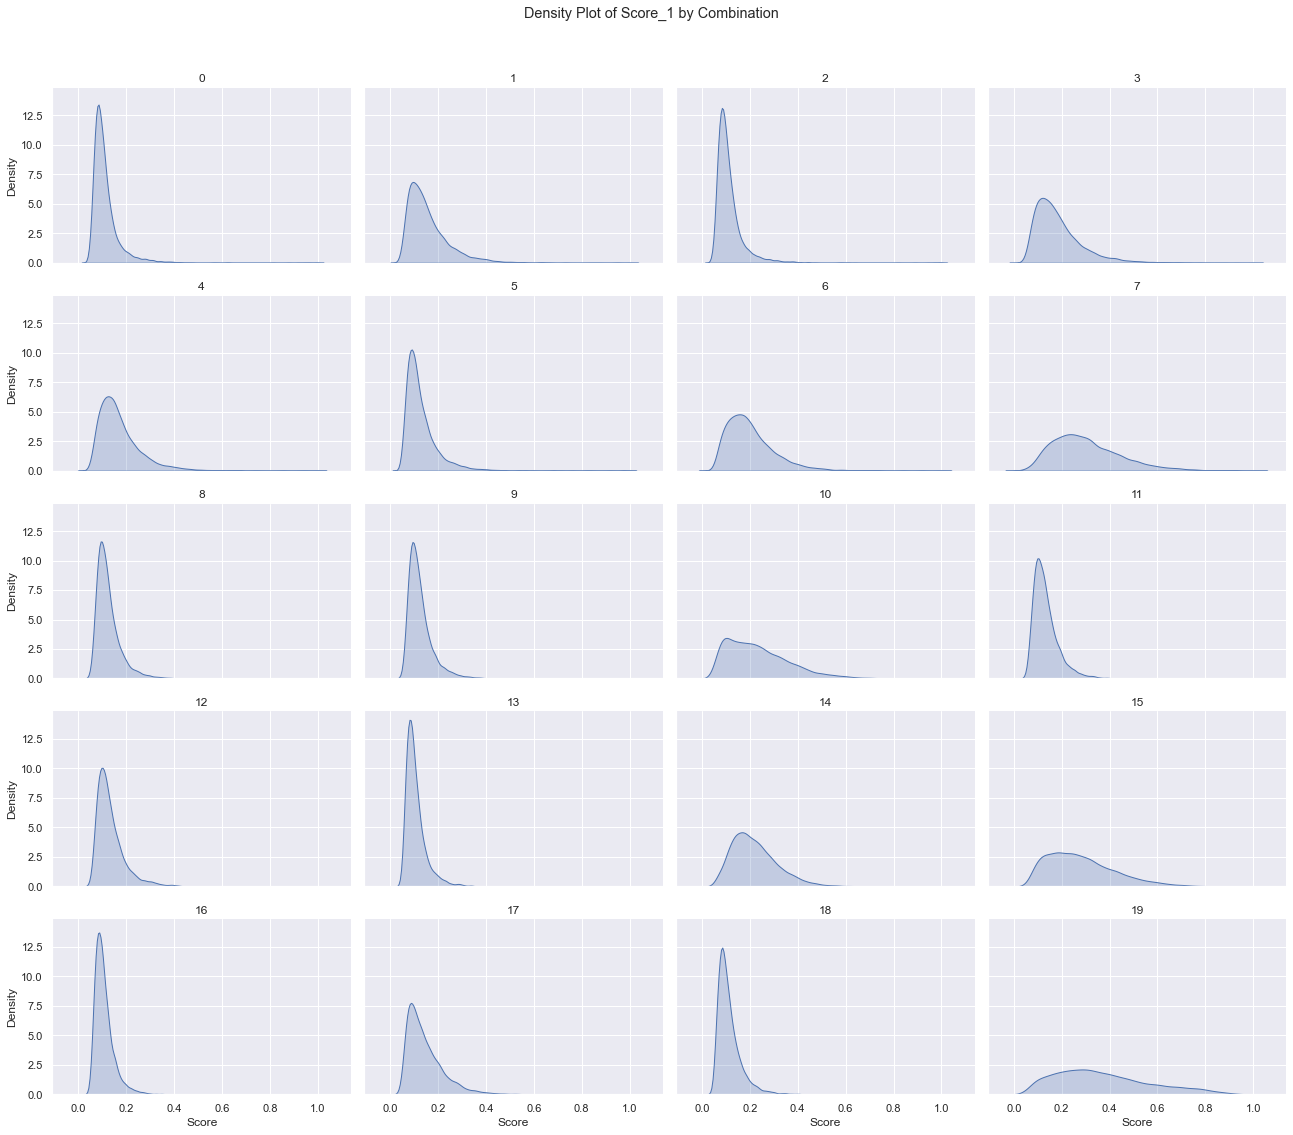

In [111]:
# facet wrap density plot for each combination
g = sns.FacetGrid(rec, col = "set_combination", col_wrap = 4, height = 3, aspect = 1.5)
g.map(sns.kdeplot, "score_1", shade = True)
g.set_titles(col_template = "{col_name}")
g.set_axis_labels("Score", "Density")
g.fig.suptitle("Density Plot of Score_1 by Combination", y = 1.05)
plt.show()

In [24]:
# create subset for "fast & furious 6"
rec_fast6 = rec[rec["movie"] == "Fast & Furious 6"]

# display row with the highest score_1
rec_fast6[rec_fast6["score_1"] == rec_fast6["score_1"].max()]

,Unnamed: 0,combination,movie,recommended_movie_1,score_1,recommended_movie_2,score_2,recommended_movie_3,score_3,recommended_movie_4,...,recommended_movie_6,score_6,recommended_movie_7,score_7,recommended_movie_8,score_8,recommended_movie_9,score_9,recommended_movie_10,score_10
20788,20788,"['new_title', 'overview', 'spoken_languages', ...",Fast & Furious 6,Furious 7,0.452835,The Fate of the Furious,0.442821,Fast Five,0.38839,Trainwreck,...,Sing,0.371084,The Secret Life of Pets 2,0.301981,Survival Family,0.271846,"Rich Man, Poor Woman in New York",0.260465,Battle: Los Angeles,0.246985


Hier wollen wir stets schauen, welche Wörter in allen Overviews am häufigsten vorkommen.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer --> convert a collection of text documents to a vector of term / token counts
count_vectorizer = CountVectorizer(stop_words="english", analyzer = "word", ngram_range=(1, 2))

word_count_matrix = count_vectorizer.fit_transform(df_movies_nlp["overview"])
word_array = count_vectorizer.get_feature_names_out()

print([word_array[i] for i in np.argsort(word_count_matrix.sum(axis=0)).tolist()[0][::-1][:5]])
print(np.sort(word_count_matrix.sum(axis=0)).tolist()[0][::-1][:5])

['life', 'year', 'live', 'world', 'young']
[4014, 3378, 2879, 2751, 2661]


## LSA
LSA (LAtent Semantic Analysis) auch bekannt als LSI (Latent Semantic Index) verwendet ein- Bag-of-Word-Modell (BoW), das zu einer Term-Dokument-Matrix führt (Vorkommen von Begriffen in einem Dokument)

Die Zeilen stehen für Begriffe und die Spalten für Dokumente. LSA lernt latente Themen, indem eine Matrixzerlegung der Dokument-Term-Matrix unter Verwendung der Singulärwertzerlegung durchgeführt wird. LSA Wird in der Regel zur Dimensionsreduzierung eingesetzt.

### SVD (Singular Value Decomposition) - Singulärwertzerlegung
SVD ist eine Matrixfaktorisierungsmethode, die eine Matrix als Produkt zweier Matrizen darstellt.

A: Input data matrix
m x n matrix (m documents, n terms)

U: Left singular vectors
m x r matrix (m documents, r concepts)

Sigma: Singular values
r x r diagonal matrix

V: Right singular vectors
n x r matrix (n terms, r concepts)

In [26]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

def prepare_corpus(data):
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(data)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in data]
    # generate LDA model
    return dictionary,doc_term_matrix

def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [ ]:
len(corpus)

18944

## Doc2Vec

NameError: name 'image' is not defined

In [ ]:
### tfidf gewichtung
### word2vec ein vektor für ein einzelnes wort
### embedings und global average
### evaluation: masking ratings from users to test the model

## User Profiles
for every user, take the movies that the user liked (rating 3.5+)
--> search for movies that are similar to the ones this user liked --> recommend 

In [34]:
# get users with more than 10 ratings
users = df_movies_ratings["userId"].value_counts()[df_movies_ratings["userId"].value_counts() > 20].index.tolist()

df_users = df_movies_ratings[df_movies_ratings["userId"].isin(users)]

In [35]:
# print unique users
print("Unique users: ", df_users["userId"].nunique())

Unique users:  26294


In [36]:
# create user-liked-movie matrix with userid as index and movieid as columns and rating as values
df_user_movie_matrix = df_users.pivot(index = "userId", columns = "movieId", values = "rating").fillna(0)

# if rating is greater than 3, set value to 1, else set value to 0
df_user_movie_matrix[df_user_movie_matrix <= 3] = 0
df_user_movie_matrix[df_user_movie_matrix > 3] = 1

df_user_movie_matrix

movieId,895,2679,4249,4484,5904,47237,47962,71677,72491,73319,...,209053,209063,209073,209085,209119,209121,209129,209131,209133,209163
userId,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [268]:
# get sample from user-movie matrix 
df_user_movie_matrix_sample = df_user_movie_matrix.sample(500, random_state = 42)

In [269]:
# for each user save all movieId where the value is 1
df_user_movie_matrix_sample["liked_movies"] = df_user_movie_matrix_sample.apply(lambda x: x[x == 1].index.tolist(), axis = 1)

# create a list of tuples with (userId, [list of liked movies])
user_movie_list = list(zip(df_user_movie_matrix_sample.index, df_user_movie_matrix_sample["liked_movies"]))

In [270]:
import random

# sample 10 movies from user index 0
user_movie_list_sample = random.sample(user_movie_list[0][1], 10)

# get titles from user_movie_list_sample
df_user_movie_list_sample = df_movies_nlp[df_movies_nlp["movieId"].isin(user_movie_list_sample)].reset_index(drop = True)

Von den gesampelten Filmen wollen wir nun die dafür vorgeschlagene Filme anschauen

In [272]:
df_user_movie_list_sample_combination = rec[rec["movie"].isin(df_user_movie_list_sample["title"])]
df_user_movie_list_sample_combination

,Unnamed: 0,combination,movie,recommended_movie_1,score_1,recommended_movie_2,score_2,recommended_movie_3,score_3,recommended_movie_4,...,recommended_movie_6,score_6,recommended_movie_7,score_7,recommended_movie_8,score_8,recommended_movie_9,score_9,recommended_movie_10,score_10
95,95,"['new_title', 'overview', 'spoken_languages', ...",Toy Story 3,Toy Story 4,0.221566,Andy Peters: Exclamation Mark Question Point,0.128434,Quarantine L.A.,0.096780,Plastic Galaxy: The Story of Star Wars Toys,...,Time Toys,0.090364,Jim & Andy: The Great Beyond,0.088873,A Dark Place Inside,0.084579,Demonic Toys: Personal Demons,0.084152,The Dry Land,0.083904
1068,1068,"['new_title', 'overview', 'spoken_languages', ...",Men in Black 3,Men in Black: International,0.194098,He Named Me Malala,0.152594,The Crazies,0.148865,Promised Land,...,The Hundred-Foot Journey,0.125077,The Worthy,0.116617,Contagion,0.115665,The Beaver,0.114737,Message Man,0.112589
1131,1131,"['new_title', 'overview', 'spoken_languages', ...",The Amazing Spider-Man,The Amazing Spider-Man 2,0.224044,Spider-Man: Into the Spider-Verse,0.144311,Spider-Man: Far from Home,0.127212,The Fjällbacka Murders: Friends for Life,...,Pan,0.077490,Mushroomers,0.074522,Heart of Stone,0.070833,One Day Since Yesterday: Peter Bogdanovich & t...,0.067888,Treehouse,0.064913
1217,1217,"['new_title', 'overview', 'spoken_languages', ...",Pitch Perfect,Pitch Perfect 2,0.069728,Yaariyan,0.065797,That Gal...Who Was in That Thing: That Guy 2,0.065142,Mistress America,...,Barry,0.055515,Milf,0.052504,Amityville: No Escape,0.051187,Her Composition,0.050852,The Raking,0.048045
1232,1232,"['new_title', 'overview', 'spoken_languages', ...",Resident Evil: Retribution,Resident Evil: Afterlife,0.211305,Resident Evil: The Final Chapter,0.169465,Sinister Squad,0.064537,Still Alice,...,Alice Through the Looking Glass,0.062456,Pompeii,0.061157,De Pernas pro Ar,0.056468,The Mortal Instruments: City of Bones,0.055910,Young Sophie Bell,0.055399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361378,361378,"['new_title', 'overview', 'spoken_languages', ...",The Hobbit: An Unexpected Journey,The Hobbit: The Desolation of Smaug,0.247406,The Hobbit: The Battle of the Five Armies,0.141227,Clash of the Empires,0.103745,Good Boys,...,"SuperManager, or Hack of the Fate",0.063289,Pecking Order,0.059205,What We Do in the Shadows,0.055693,The Dance Exponents: Why Does Love?,0.055025,Night at the Museum: Secret of the Tomb,0.053157
362191,362191,"['new_title', 'overview', 'spoken_languages', ...",The Hunger Games: Catching Fire,The Hunger Games: Mockingjay - Part 2,0.209238,The Hunger Games,0.189724,The Hunger Games: Mockingjay - Part 1,0.185148,The Hungover Games,...,Liar Game: Reborn,0.059295,High Strung,0.052323,The Trap,0.052220,Nantucket Film Festival's Comedy Roundtable,0.051872,Blind Date,0.051852
362333,362333,"['new_title', 'overview', 'spoken_languages', ...",Divergent,August: Osage County,0.086753,OzLand,0.069762,London Has Fallen,0.065235,The Child in Time,...,Unthinkable,0.052700,Phil,0.049058,Unlocked,0.046586,Diverge,0.046134,The Oath,0.045599
362888,362888,"['new_title', 'overview', 'spoken_languages', ...",Into the Storm,Stonados,0.098822,The Perfect Host,0.061735,The Rocky Horror Picture Show: Let's Do the Ti...,0.057869,The Hateful Eight,...,Take Shelter,0.048170,Alien Tornado,0.046904,Corner Gas: The Movie,0.045323,Nailbiter,0.044093,Storm Seekers,0.042598


In [264]:
# convert unique combinations to list
old_combinations = df_user_movie_list_sample_combination["combination"].unique()

combinations = []
for i in old_combinations:
    # remove ' from i
    i = i.replace("'", "")
    # replace [ 
    i = i.replace("[", "")
    # replace ]
    i = i.replace("]", "")
    # split
    i = i.split(", ")

    combinations.append(i)

In [275]:
df_user_movie_list_sample_combination["set_combination"] = df_user_movie_list_sample_combination.groupby(df_user_movie_list_sample_combination["combination"].map(tuple)).ngroup()

C:\Users\Alex\AppData\Local\Temp/ipykernel_18688/4184100356.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_movie_list_sample_combination["set_combination"] = df_user_movie_list_sample_combination.groupby(df_user_movie_list_sample_combination["combination"].map(tuple)).ngroup()


In [287]:
# group by set_combination and get all recommended movies
df_user_movie_list_sample_combination2 = df_user_movie_list_sample_combination.groupby("set_combination")

In [288]:
df_user_movie_list_sample_combination2

,set_combination,0
0,0,"[recommended_movie_1, recommended_movie_2]"
1,1,"[recommended_movie_1, recommended_movie_2]"
2,2,"[recommended_movie_1, recommended_movie_2]"
3,3,"[recommended_movie_1, recommended_movie_2]"
4,4,"[recommended_movie_1, recommended_movie_2]"
5,5,"[recommended_movie_1, recommended_movie_2]"
6,6,"[recommended_movie_1, recommended_movie_2]"
7,7,"[recommended_movie_1, recommended_movie_2]"
8,8,"[recommended_movie_1, recommended_movie_2]"
9,9,"[recommended_movie_1, recommended_movie_2]"


In [276]:
df_user_movie_list_sample_combination

,Unnamed: 0,combination,movie,recommended_movie_1,score_1,recommended_movie_2,score_2,recommended_movie_3,score_3,recommended_movie_4,...,score_6,recommended_movie_7,score_7,recommended_movie_8,score_8,recommended_movie_9,score_9,recommended_movie_10,score_10,set_combination
95,95,"['new_title', 'overview', 'spoken_languages', ...",Toy Story 3,Toy Story 4,0.221566,Andy Peters: Exclamation Mark Question Point,0.128434,Quarantine L.A.,0.096780,Plastic Galaxy: The Story of Star Wars Toys,...,0.090364,Jim & Andy: The Great Beyond,0.088873,A Dark Place Inside,0.084579,Demonic Toys: Personal Demons,0.084152,The Dry Land,0.083904,9
1068,1068,"['new_title', 'overview', 'spoken_languages', ...",Men in Black 3,Men in Black: International,0.194098,He Named Me Malala,0.152594,The Crazies,0.148865,Promised Land,...,0.125077,The Worthy,0.116617,Contagion,0.115665,The Beaver,0.114737,Message Man,0.112589,9
1131,1131,"['new_title', 'overview', 'spoken_languages', ...",The Amazing Spider-Man,The Amazing Spider-Man 2,0.224044,Spider-Man: Into the Spider-Verse,0.144311,Spider-Man: Far from Home,0.127212,The Fjällbacka Murders: Friends for Life,...,0.077490,Mushroomers,0.074522,Heart of Stone,0.070833,One Day Since Yesterday: Peter Bogdanovich & t...,0.067888,Treehouse,0.064913,9
1217,1217,"['new_title', 'overview', 'spoken_languages', ...",Pitch Perfect,Pitch Perfect 2,0.069728,Yaariyan,0.065797,That Gal...Who Was in That Thing: That Guy 2,0.065142,Mistress America,...,0.055515,Milf,0.052504,Amityville: No Escape,0.051187,Her Composition,0.050852,The Raking,0.048045,9
1232,1232,"['new_title', 'overview', 'spoken_languages', ...",Resident Evil: Retribution,Resident Evil: Afterlife,0.211305,Resident Evil: The Final Chapter,0.169465,Sinister Squad,0.064537,Still Alice,...,0.062456,Pompeii,0.061157,De Pernas pro Ar,0.056468,The Mortal Instruments: City of Bones,0.055910,Young Sophie Bell,0.055399,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361378,361378,"['new_title', 'overview', 'spoken_languages', ...",The Hobbit: An Unexpected Journey,The Hobbit: The Desolation of Smaug,0.247406,The Hobbit: The Battle of the Five Armies,0.141227,Clash of the Empires,0.103745,Good Boys,...,0.063289,Pecking Order,0.059205,What We Do in the Shadows,0.055693,The Dance Exponents: Why Does Love?,0.055025,Night at the Museum: Secret of the Tomb,0.053157,16
362191,362191,"['new_title', 'overview', 'spoken_languages', ...",The Hunger Games: Catching Fire,The Hunger Games: Mockingjay - Part 2,0.209238,The Hunger Games,0.189724,The Hunger Games: Mockingjay - Part 1,0.185148,The Hungover Games,...,0.059295,High Strung,0.052323,The Trap,0.052220,Nantucket Film Festival's Comedy Roundtable,0.051872,Blind Date,0.051852,16
362333,362333,"['new_title', 'overview', 'spoken_languages', ...",Divergent,August: Osage County,0.086753,OzLand,0.069762,London Has Fallen,0.065235,The Child in Time,...,0.052700,Phil,0.049058,Unlocked,0.046586,Diverge,0.046134,The Oath,0.045599,16
362888,362888,"['new_title', 'overview', 'spoken_languages', ...",Into the Storm,Stonados,0.098822,The Perfect Host,0.061735,The Rocky Horror Picture Show: Let's Do the Ti...,0.057869,The Hateful Eight,...,0.048170,Alien Tornado,0.046904,Corner Gas: The Movie,0.045323,Nailbiter,0.044093,Storm Seekers,0.042598,16


In [163]:
df_movies_nlp_copy = df_movies_nlp.copy()

# drop columns genres, release_date, bow
#df_movies_nlp_copy.drop(["genres", "release_date", "bow"], axis = 1, inplace = True)

# remove movies from df_movies_nlp_copy that are in user_movie_list_sample
#df_movies_nlp_copy = df_movies_nlp_copy[~df_movies_nlp_copy["movieId"].isin(user_movie_list_sample)]

In [221]:
# returns a dataframe that contains each movie with its 10 top recommended movies and scores
def recommendations2(df):

    # initialize the new dataframe
    df_movies_recommended = pd.DataFrame()

    # loop through 20 combinations of columns
    for combination in combinations:
        
        # add cols to column tfidf
        df["tfidf"] = df[combination].apply(" ".join, axis=1)

        # create cosine similarity matrix
        cosine_sim = create_cosine(df["tfidf"])

        # loop through all movies
        for movie in df_user_movie_list_sample["title"]:   

            # get 10  movie recommendations for each movie based on cosine similarity matrix
            recommended_movies = recommend_movies(df, movie, cosine_sim)  

            # add ccolumn combination, movie, recommended movies and scores to dataframe
            df_movies_recommended = df_movies_recommended.append({
                "combination": combination, 
                "movie": movie,
                "recommended_movie_1":  recommended_movies[0][0],
                "score_1": recommended_movies[0][1], 
                "recommended_movie_2": recommended_movies[1][0],
                "score_2": recommended_movies[1][1],
                "recommended_movie_3": recommended_movies[2][0],
                "score_3": recommended_movies[2][1],
                "recommended_movie_4": recommended_movies[3][0],
                "score_4": recommended_movies[3][1],
                "recommended_movie_5": recommended_movies[4][0],
                "score_5": recommended_movies[4][1],
                "recommended_movie_6": recommended_movies[5][0],
                "score_6": recommended_movies[5][1],
                "recommended_movie_7": recommended_movies[6][0],
                "score_7": recommended_movies[6][1],
                "recommended_movie_8": recommended_movies[7][0],
                "score_8": recommended_movies[7][1],
                "recommended_movie_9": recommended_movies[8][0],
                "score_9": recommended_movies[8][1],
                "recommended_movie_10": recommended_movies[9][0],
                "score_10": recommended_movies[9][1]
            }, ignore_index = True)

    return df_movies_recommended

df_movies_recommended2 = recommendations2(df_movies_nlp_copy)

In [222]:
df_movies_recommended2["set_combination"] = df_movies_recommended2.groupby(df_movies_recommended2["combination"].map(tuple)).ngroup()

In [237]:
# group by set_combination and extract all recommended movies into a list
df_movies_recommended2.loc[0][2]

'Iron Man 3'

In [251]:
# group by set_combination and extract all recomended movies
df_movies_recommended3 = df_movies_recommended2.groupby("set_combination")["recommended_movie_1", "recommended_movie_2", "recommended_movie_3", "recommended_movie_4", "recommended_movie_5", "recommended_movie_6", "recommended_movie_7", "recommended_movie_8", "recommended_movie_9", "recommended_movie_10"].apply(list)

C:\Users\Alex\AppData\Local\Temp/ipykernel_18688/246235815.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_movies_recommended3 = df_movies_recommended2.groupby("set_combination")["recommended_movie_1", "recommended_movie_2", "recommended_movie_3", "recommended_movie_4", "recommended_movie_5", "recommended_movie_6", "recommended_movie_7", "recommended_movie_8", "recommended_movie_9", "recommended_movie_10"].apply(list)


In [252]:
df_movies_recommended3

set_combination
0     [recommended_movie_1, recommended_movie_2, rec...
1     [recommended_movie_1, recommended_movie_2, rec...
2     [recommended_movie_1, recommended_movie_2, rec...
3     [recommended_movie_1, recommended_movie_2, rec...
4     [recommended_movie_1, recommended_movie_2, rec...
5     [recommended_movie_1, recommended_movie_2, rec...
6     [recommended_movie_1, recommended_movie_2, rec...
7     [recommended_movie_1, recommended_movie_2, rec...
8     [recommended_movie_1, recommended_movie_2, rec...
9     [recommended_movie_1, recommended_movie_2, rec...
10    [recommended_movie_1, recommended_movie_2, rec...
11    [recommended_movie_1, recommended_movie_2, rec...
12    [recommended_movie_1, recommended_movie_2, rec...
13    [recommended_movie_1, recommended_movie_2, rec...
14    [recommended_movie_1, recommended_movie_2, rec...
15    [recommended_movie_1, recommended_movie_2, rec...
16    [recommended_movie_1, recommended_movie_2, rec...
17    [recommended_movie_1, reco

In [220]:
# groupby combination
df_movies_recommended2

,set_combination,recommended_movie_1,score_1,recommended_movie_2,score_2,recommended_movie_3,score_3,recommended_movie_4,score_4,recommended_movie_5,...,recommended_movie_6,score_6,recommended_movie_7,score_7,recommended_movie_8,score_8,recommended_movie_9,score_9,recommended_movie_10,score_10
0,0,Iron Man 3I am ThorPirates of the Caribbean: D...,1.862802,Iron Man & Captain America: Heroes UnitedThor:...,1.329258,Iron Man & Hulk: Heroes UnitedThor: RagnarokTh...,1.116058,Marvel Rising: Heart of IronMarvel Super Hero ...,0.776188,Rise of the SuperheroesKon-TikiElektra LuxxDum...,...,Captain America: Civil WarHeartstoneStolen Sea...,0.667022,The Man with the Iron FistsMarvel Studios: Ass...,0.642313,Avengers: Age of UltronJack the Giant SlayerTi...,0.610141,Marvel Studios: Assembling a UniverseEcstasy o...,0.591577,"Marvel Super Hero Adventures: Frost Fight!10,0...",0.575782
1,1,Iron Man 3Thor: The Dark WorldPirates of the C...,3.016430,Iron Man & Captain America: Heroes UnitedThor:...,2.072040,Marvel Studios: Assembling a UniverseI am Thor...,1.754917,Iron Man & Hulk: Heroes UnitedMarvel Studios: ...,1.327518,Captain America: Civil WarCaptain MarvelThe Ju...,...,Marvel Rising: Heart of IronDoctor StrangeFroz...,1.056276,Captain MarvelMarvel Super Hero Adventures: Fr...,0.993820,Avengers: Age of UltronIron Man 3ZootopiaCats ...,0.954794,Doctor StrangeGuardians of the GalaxyGemini Ma...,0.921925,The Man with the Iron FistsGuardians of the Ga...,0.886973
2,2,Iron Man 3I am ThorPirates of the Caribbean: D...,1.790230,Iron Man & Captain America: Heroes UnitedThor:...,1.302613,Iron Man & Hulk: Heroes UnitedThor: RagnarokPa...,1.112289,Marvel Rising: Heart of IronMarvel Super Hero ...,0.769305,Rise of the SuperheroesKon-TikiPirate's Passag...,...,The Man with the Iron FistsHeartstoneElektra L...,0.666869,Captain America: Civil WarJack the Giant Slaye...,0.640903,Avengers: Age of UltronEcstasy of Order: The T...,0.609575,"Marvel Super Hero Adventures: Frost Fight!10,0...",0.581998,Stories of Love That Cannot Belong to This Wor...,0.564899
3,3,Iron Man 3Thor: The Dark WorldPirates of the C...,3.727723,Iron Man & Captain America: Heroes UnitedI am ...,2.509709,Marvel Studios: Assembling a UniverseThor: Rag...,2.063175,Iron Man & Hulk: Heroes UnitedMarvel Studios: ...,1.562619,Marvel Rising: Heart of IronCaptain MarvelThe ...,...,The Man with the Iron FistsDoctor StrangeFroze...,1.225372,Captain America: Civil WarIron Man 3NoelleHarr...,1.181460,Captain MarvelGuardians of the GalaxyBig Hero ...,1.135345,Doctor StrangeMarvel Super Hero Adventures: Fr...,1.058394,The Man with the Iron Fists 2The AvengersMcFar...,1.030378
4,4,Iron Man 3Thor: The Dark WorldPirates of the C...,3.124902,Iron Man & Captain America: Heroes UnitedI am ...,2.130900,Marvel Studios: Assembling a UniverseThor: Rag...,1.779414,Iron Man & Hulk: Heroes UnitedMarvel Studios: ...,1.341072,Marvel Rising: Heart of IronCaptain MarvelThe ...,...,Captain America: Civil WarDoctor StrangeThe Lo...,1.081806,Captain MarvelMarvel Super Hero Adventures: Fr...,1.015703,The Man with the Iron FistsIron Man 3Frozen II...,0.988871,Avengers: Age of UltronGuardians of the Galaxy...,0.944738,Captain America: The First AvengerGuardians of...,0.905188
5,5,Iron Man 3Thor: The Dark WorldPirates of the C...,2.249174,Iron Man & Captain America: Heroes UnitedThor:...,1.550729,Marvel Studios: Assembling a UniverseI am Thor...,1.288203,Iron Man & Hulk: Heroes UnitedMarvel Studios: ...,0.986748,Captain America: Civil WarMarvel Super Hero Ad...,...,Marvel Rising: Heart of IronCaptain MarvelFroz...,0.818344,Avengers: Age of UltronDoctor StrangeMcFarland...,0.780419,Rise of the SuperheroesMarvel RenaissanceThe J...,0.740103,Captain MarvelGuardians of the GalaxyNoelleDum...,0.699273,Marvel RenaissanceIron Man 312 StrongThe Wizar...,0.674744
6,6,Iron Man 3Thor: The Dark WorldPirates of the C...,3.685172,Marvel Studios: Assembling a UniverseThor: Rag...,2.588484,Iron Man & Captain America: Heroes UnitedI am